In [226]:
import pandas as pd

In [227]:
df=pd.read_csv("partial_scraping.csv")

In [228]:
type(df["Salary"][0])

float

In [229]:
df['Title'].unique().tolist()

['Data Engineer SPARK/SCALA (H/F)',
 'Big Data Engineer H/F',
 'Data Scientist / Data Miner / Freelance',
 'Data Engineer (H/F) / Freelance',
 'INGENIEUR DEVELOPPEMENT BIG DATA - F/H',
 'CONSULTANT BIG DATA - F/H',
 'Data Engineer (H/F)',
 'Chef de projet/Consultant microsoft Big Data',
 'ARCHITECTE BIG DATA - F/H',
 'DATA CONCEPTEUR - H/F',
 'Data Analyst (F/H)',
 'Data Scientist (F/H)',
 'Data Engineer / Développeur NLP H/F',
 'Data Engineer - Python H/F',
 'Chef de projet/Architecte BI Data Platform',
 'DÉVELOPPEUR BIG DATA (F/H)',
 'CHEF DE PROJET "MASTER DATA" - H/F',
 'Consultant / Auditeur Data Protection – Data Privacy (F/H)',
 'Data Scientist - Paris',
 'CONSULTANT BIG DATA/JAVA - F/H',
 'Tech Lead Data / Freelance',
 'GESTIONNAIRE MASTER DATA - MOA (H/F)',
 'Avocat data protection min (H/F)',
 'Advertising Data Analyst',
 'Growth Strategy & Operations - Data Analyst Intern (Paris)',
 'Data Scientist H/F',
 'Sales Data Analyst / BI - H/F',
 'Data Scientist / Engineer',
 'Senio

In [230]:
df["Salary"].fillna("None", inplace = True)

# Création Fonction Split_city

In [231]:
def split_city(row):
    location = row["Location"]
    if "Paris" in location or location == "France":
        city = "Paris"
        code_postal = "75"
    elif "Lyon" in location:
        city = "Lyon"
        code_postal = "69"
    elif "(" in location:
        split = location.split("(")
        city = split[0]
        code_postal = split[1]
    else:
        city = "None"
        code_postal="None"
    
    row["city"] = city
    row["cp"] = code_postal.replace(")","")
    return row

# Création colonne city et cp

In [232]:
df = df.apply(split_city, axis=1)

# Création Fonction Split Salary

In [233]:
def split_salary(row):
    salary = row["Salary"]
    if "-" in salary:
        split = salary.split("-")
        salary_min = split[0]
        salary_max = split[1]
    else:
        salary_min = salary
        salary_max = salary
    
    row["salary_min"] = salary_min.replace("€","").replace("par mois","").replace("par semaine","").replace("par an","").replace("\xa0","")
    row["salary_max"] = salary_max.replace("€","").replace("par mois","").replace("par semaine","").replace("par an","").replace("\xa0","")
    
    if "mois" in row["Salary"]:
        row["salary_min"] = int(row["salary_min"])*12
        row["salary_max"] = int(row["salary_max"])*12
    
    if "semaine" in row["Salary"]:
        row["salary_min"] = int(row["salary_min"])*52
        row["salary_max"] = int(row["salary_max"])*52
        
    return row

# Création des colonnes salary max et salary min

In [241]:
df_salary = df[df["Salary"] != "None"]
df_salary = df_salary.apply(split_salary, axis=1)
df_salary["salary_min"]=pd.to_numeric(df_salary["salary_min"],'coerce')
df_salary["salary_max"]=pd.to_numeric(df_salary["salary_max"],'coerce')
#df_salary["salary_mean"]=pd.to_numeric(df_salary["salary_mean"],'coerce')

In [242]:
df_salary

,_id,Title,Company,Location,Salary,Description,Date,Job_Search,Department_Search,city,cp,salary_min,salary_max
1,p_af45e2a447bae65b,Big Data Engineer H/F,Square Sense,Paris (75),50 000 € - 60 000 € par an,"Technology domains: Kafka, Spark, Python, Java...",07/10/2019,Data,75,Paris,75,50000.0,60000.0
3,p_9ba1a3ab379e9b6e,Data Engineer (H/F) / Freelance,Human Job,Paris (75),500 € par mois,Soutenir le développement de la plateforme BIG...,07/10/2019,Data,75,Paris,75,6000.0,6000.0
4,p_8ccc668de734a40e,Data Engineer (H/F) / Freelance,HR-TEAM,Paris (75),500 € - 650 € par mois,Contexte : Nous recherchons aujourd’hui plusie...,07/10/2019,Data,75,Paris,75,6000.0,7800.0
24,p_4ed079af45cf052d,Advertising Data Analyst,Work4 Labs,Paris 9e (75),1 000 € par semaine,Tu es intrigué par le potentiel de Facebook po...,07/10/2019,Data,75,Paris,75,52000.0,52000.0
26,p_8d5f755b3a18ea80,Data Scientist H/F,HPR,Paris (75),45 000 € - 55 000 € par an,"Contexte : Nous recherchons pour notre client,...",05/10/2019,Data,75,Paris,75,45000.0,55000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,pj_edab0aa260675678,Centre-ville / Client final / Développeur Full...,Delia Technologies,Nantes (44),37 000 € - 40 000 € par an,Delia Technologies #LaDevOpsFamily Delia Techn...,04/10/2019,Développeur,Loire-Atlantique,Nantes,44,37000.0,40000.0
1574,pj_fd8e78ca8bedfe98,Web Developpeur,CLERE / JES,Loire-Atlantique,22 000 € - 28 000 € par an,"Éditeur de logiciels, nous développons en inte...",NaN,Développeur,Loire-Atlantique,None,None,22000.0,28000.0
1575,pj_22591ff93321d73e,Startup / Centre-ville / Développeur Java Back...,Delia Technologies,Nantes (44),40 000 € par an,Delia Technologies #LaDevOpsFamily Delia Techn...,04/10/2019,Développeur,Loire-Atlantique,Nantes,44,40000.0,40000.0
1579,p_eaa327fac777da3b,DÉVELOPPEUR INFORMATIQUE INDUSTRIELLE .NET (F/H),Randstad Search,L'Union (31),34 000 € par an,Rejoins un bureau d'étude spécialisé dans l'au...,07/10/2019,Développeur,Haute-Garonne,L'Union,31,34000.0,34000.0


## Création colonne salary mean

In [243]:
df_salary["salary_mean"] = (df_salary["salary_min"]+df_salary["salary_max"])/2

In [244]:
df_salary

,_id,Title,Company,Location,Salary,Description,Date,Job_Search,Department_Search,city,cp,salary_min,salary_max,salary_mean
1,p_af45e2a447bae65b,Big Data Engineer H/F,Square Sense,Paris (75),50 000 € - 60 000 € par an,"Technology domains: Kafka, Spark, Python, Java...",07/10/2019,Data,75,Paris,75,50000.0,60000.0,55000.0
3,p_9ba1a3ab379e9b6e,Data Engineer (H/F) / Freelance,Human Job,Paris (75),500 € par mois,Soutenir le développement de la plateforme BIG...,07/10/2019,Data,75,Paris,75,6000.0,6000.0,6000.0
4,p_8ccc668de734a40e,Data Engineer (H/F) / Freelance,HR-TEAM,Paris (75),500 € - 650 € par mois,Contexte : Nous recherchons aujourd’hui plusie...,07/10/2019,Data,75,Paris,75,6000.0,7800.0,6900.0
24,p_4ed079af45cf052d,Advertising Data Analyst,Work4 Labs,Paris 9e (75),1 000 € par semaine,Tu es intrigué par le potentiel de Facebook po...,07/10/2019,Data,75,Paris,75,52000.0,52000.0,52000.0
26,p_8d5f755b3a18ea80,Data Scientist H/F,HPR,Paris (75),45 000 € - 55 000 € par an,"Contexte : Nous recherchons pour notre client,...",05/10/2019,Data,75,Paris,75,45000.0,55000.0,50000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,pj_edab0aa260675678,Centre-ville / Client final / Développeur Full...,Delia Technologies,Nantes (44),37 000 € - 40 000 € par an,Delia Technologies #LaDevOpsFamily Delia Techn...,04/10/2019,Développeur,Loire-Atlantique,Nantes,44,37000.0,40000.0,38500.0
1574,pj_fd8e78ca8bedfe98,Web Developpeur,CLERE / JES,Loire-Atlantique,22 000 € - 28 000 € par an,"Éditeur de logiciels, nous développons en inte...",NaN,Développeur,Loire-Atlantique,None,None,22000.0,28000.0,25000.0
1575,pj_22591ff93321d73e,Startup / Centre-ville / Développeur Java Back...,Delia Technologies,Nantes (44),40 000 € par an,Delia Technologies #LaDevOpsFamily Delia Techn...,04/10/2019,Développeur,Loire-Atlantique,Nantes,44,40000.0,40000.0,40000.0
1579,p_eaa327fac777da3b,DÉVELOPPEUR INFORMATIQUE INDUSTRIELLE .NET (F/H),Randstad Search,L'Union (31),34 000 € par an,Rejoins un bureau d'étude spécialisé dans l'au...,07/10/2019,Développeur,Haute-Garonne,L'Union,31,34000.0,34000.0,34000.0


## Quantiles salary min

In [245]:
df_salary.salary_min.describe()

count      262.000000
mean     38556.290076
std      13586.442247
min        300.000000
25%      30000.000000
50%      40000.000000
75%      47750.000000
max      75000.000000
Name: salary_min, dtype: float64

## Quantiles salary max

In [246]:
df_salary.salary_max.describe()

count       259.000000
mean      46163.042471
std       16153.745622
min        6000.000000
25%       39200.000000
50%       50000.000000
75%       55000.000000
max      110000.000000
Name: salary_max, dtype: float64

## Quantiles salary mean

In [247]:
df_salary.salary_mean.describe()

count      259.000000
mean     42581.227799
std      14099.161855
min       6000.000000
25%      35750.000000
50%      44000.000000
75%      50000.000000
max      90000.000000
Name: salary_mean, dtype: float64

# Création colonne class label par rapport aux quantiles salary mean

In [248]:
def classification(x):
    if x <= 35750:
        label = 0
    elif x > 35750 and x <= 44000:
        label = 1
    elif x > 44000 and x <= 50000:
        label = 2
    else:
        label = 3
        
    return label

df_salary["salary_label"] = df_salary.salary_mean.apply(classification)

In [251]:
def classification_min(x):
    if x <= 30000:
        label = 0
    elif x > 30000 and x <= 40000:
        label = 1
    elif x > 40000 and x <= 47750:
        label = 2
    else:
        label = 3
        
    return label

df_salary["label_salary_min"] = df_salary.salary_min.apply(classification_min)

In [329]:
#df_salary.drop(columns = 'label_salary_mean', inplace=True)

In [256]:
df_salary.sample(10)

,_id,Title,Company,Location,Salary,Description,Date,Job_Search,Department_Search,city,cp,salary_min,salary_max,salary_mean,salary_label,label_salary_min
1321,p_25edb626640d7eb4,Developpeur Java H/F,Page Personnel,Paris (75),42 000 € - 50 000 € par an,"Notre client, jeune start up dans le milieu de...",21/09/2019,Développeur,75,Paris,75,42000.0,50000.0,46000.0,2,2
533,p_faff6ea87965d77a,Data Tech Lead / Data Consultant F/H,Thélio,Bordeaux (33),35 000 € - 45 000 € par an,THELIO Et si vous rejoigniez une équipe bordel...,07/09/2019,Data,Gironde,Bordeaux,33,35000.0,45000.0,40000.0,1,1
1434,p_347e93c616006d41,Développeur full-stack Php 5/7 H/F (Paris,Sintel,Paris (75),43 000 € - 45 000 € par an,"Contract type CDI Location Paris Salary 43,000...",07/09/2019,Développeur,75,Paris,75,43000.0,45000.0,44000.0,1,2
389,p_be63db7f87b4398c,DATA SCIENTIST (F/H),Expectra.fr,Paris (75),40 000 € par an,"Expectra, leader en France de l'intérim spécia...",17/09/2019,Data,75,Paris,75,40000.0,40000.0,40000.0,1,1
1519,pj_5dc1fb5a284c5d31,Développeur,Ratp Smart Systems,Bordeaux (33),38 000 € - 45 000 € par an,Première filiale régionale de Ratp Smart Syste...,NaN,Développeur,Gironde,Bordeaux,33,38000.0,45000.0,41500.0,1,1
1333,p_90e5af680ba853e7,Développeur .Net Full Stack (H/F),Easy Partner,Paris (75),55 000 € par an,### La société Notre client innove en permanen...,18/09/2019,Développeur,75,Paris,75,55000.0,55000.0,55000.0,3,3
1552,p_39fe17f0132cebe7,Développeur PHP H/F,KELTIS,Rillieux-la-Pape (69),33 000 € - 45 000 € par an,"KELTIS, Cabinet de recrutement implanté sur la...",04/10/2019,Développeur,Rhône,Rillieux-la-Pape,69,33000.0,45000.0,39000.0,1,1
928,p_aebcdbafd8398f28,Technicien réseau Hotline Téléphonie Data (H/F),Manpower,Saint-Orens-de-Gameville (31),22 500 € - 24 000 € par an,L'entreprise Manpower TOULOUSE INFORMATIQUE re...,07/09/2019,Data,Haute-Garonne,Saint-Orens-de-Gameville,31,22500.0,24000.0,23250.0,0,0
750,p_b10a349a77be7c20,ASSISTANT DATA (F/H),Randstad Search,Nantes (44),1 699 € par mois,Nous recherchons pour le compte de notre clien...,07/10/2019,Data,Loire-Atlantique,Nantes,44,20388.0,20388.0,20388.0,0,0
1069,pj_df0c59ab5144d3dc,Développeur Full Stack en environnement Agile ...,Synchrone,Paris (75),38 000 € - 45 000 € par an,"Notre Entreprise Spécialisée en Consulting, Da...",04/10/2019,Développeur,75,Paris,75,38000.0,45000.0,41500.0,1,1


# Création des df par tranches label

In [258]:
label_0 = df_salary[df_salary["salary_label"]==0]
label_1 = df_salary[df_salary["salary_label"]==1]
label_2 = df_salary[df_salary["salary_label"]==2]
label_3 = df_salary[df_salary["salary_label"]==3]

In [259]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

### Création de la fonction qui retourne les mots relevants sur la colonne title

In [260]:
def clean_title(title):
    title = word_tokenize(title)
    #desc = [word.lower() for word in desc if word.isalpha() and len(word)>2]
    title = [word.lower() for word in title if (word.isalpha() or word.isdigit()) and len(word)>2]
    title = [word for word in title if word not in stop_words]
    return title

### On applique la fonction sur chaque df

In [261]:
stop_words = stopwords.words('french')
tag_title_0 = label_0["Title"].apply(clean_title)
tag_title_1 = label_1["Title"].apply(clean_title)    
tag_title_2 = label_2["Title"].apply(clean_title)
tag_title_3 = label_3["Title"].apply(clean_title)

In [262]:
from collections import Counter
result_0 = tag_title_0.apply(Counter).sum().items() # créer un dictionnaire avec la frequence de chaque mot de tag_title1
result_0 = sorted(result_0, key=lambda kv : kv[1], reverse=True) #on va ordonner par la valeur du dictionnaire en ordre descendant

result_1 = tag_title_1.apply(Counter).sum().items()
result_1 = sorted(result_1, key=lambda kv : kv[1], reverse=True)

result_2 = tag_title_2.apply(Counter).sum().items()
result_2 = sorted(result_2, key=lambda kv : kv[1], reverse=True)

result_3 = tag_title_3.apply(Counter).sum().items()
result_3 = sorted(result_3, key=lambda kv : kv[1], reverse=True)

### Je crée le dictionnaire qui associe la frequece de chaque mot sur chaque df

In [263]:
result_series_0 = {k: v for k,v in result_0}
result_series_1 = {k: v for k,v in result_1}
result_series_2 = {k: v for k,v in result_2}
result_series_3 = {k: v for k,v in result_3}

In [274]:
result_series_0

{'data': 35,
 'développeur': 27,
 'freelance': 20,
 'stage': 8,
 'informatique': 8,
 'engineer': 6,
 'analyst': 5,
 'scientist': 5,
 'web': 5,
 'developpeur': 4,
 'assistant': 4,
 'junior': 3,
 'center': 3,
 'chef': 3,
 'projet': 3,
 'big': 3,
 'stagiaire': 3,
 'java': 3,
 'projeteur': 2,
 'technicien': 2,
 'python': 2,
 'manager': 2,
 'mois': 2,
 'géo': 2,
 'cdi': 2,
 'front': 2,
 'contrôleur': 1,
 'gestion': 1,
 'consultant': 1,
 'expérimenté': 1,
 'quality': 1,
 'azure': 1,
 'technical': 1,
 'leader': 1,
 'google': 1,
 'cloud': 1,
 'platform': 1,
 'banque': 1,
 'ligne': 1,
 'sénior': 1,
 'tableau': 1,
 'scala': 1,
 'agile': 1,
 'architect': 1,
 'tech': 1,
 'lead': 1,
 'dev': 1,
 'bon': 1,
 'anglais': 1,
 'sql': 1,
 'ingénieur': 1,
 'customer': 1,
 'management': 1,
 '2020': 1,
 'région': 1,
 'lyon': 1,
 'controller': 1,
 'webmarketing': 1,
 'sequencage': 1,
 'confirmé': 1,
 'nantes': 1,
 'réseau': 1,
 'hotline': 1,
 'téléphonie': 1,
 'sharepoint': 1,
 'paris': 1,
 'php': 1,
 'intégra

# Visualisation du wordcloud title de chaque df

In [266]:
from wordcloud import WordCloud

In [268]:
wordcloud_0 = WordCloud().generate_from_frequencies(result_series_0)
wordcloud_1 = WordCloud().generate_from_frequencies(result_series_1)
wordcloud_2 = WordCloud().generate_from_frequencies(result_series_2)
wordcloud_3 = WordCloud().generate_from_frequencies(result_series_3)

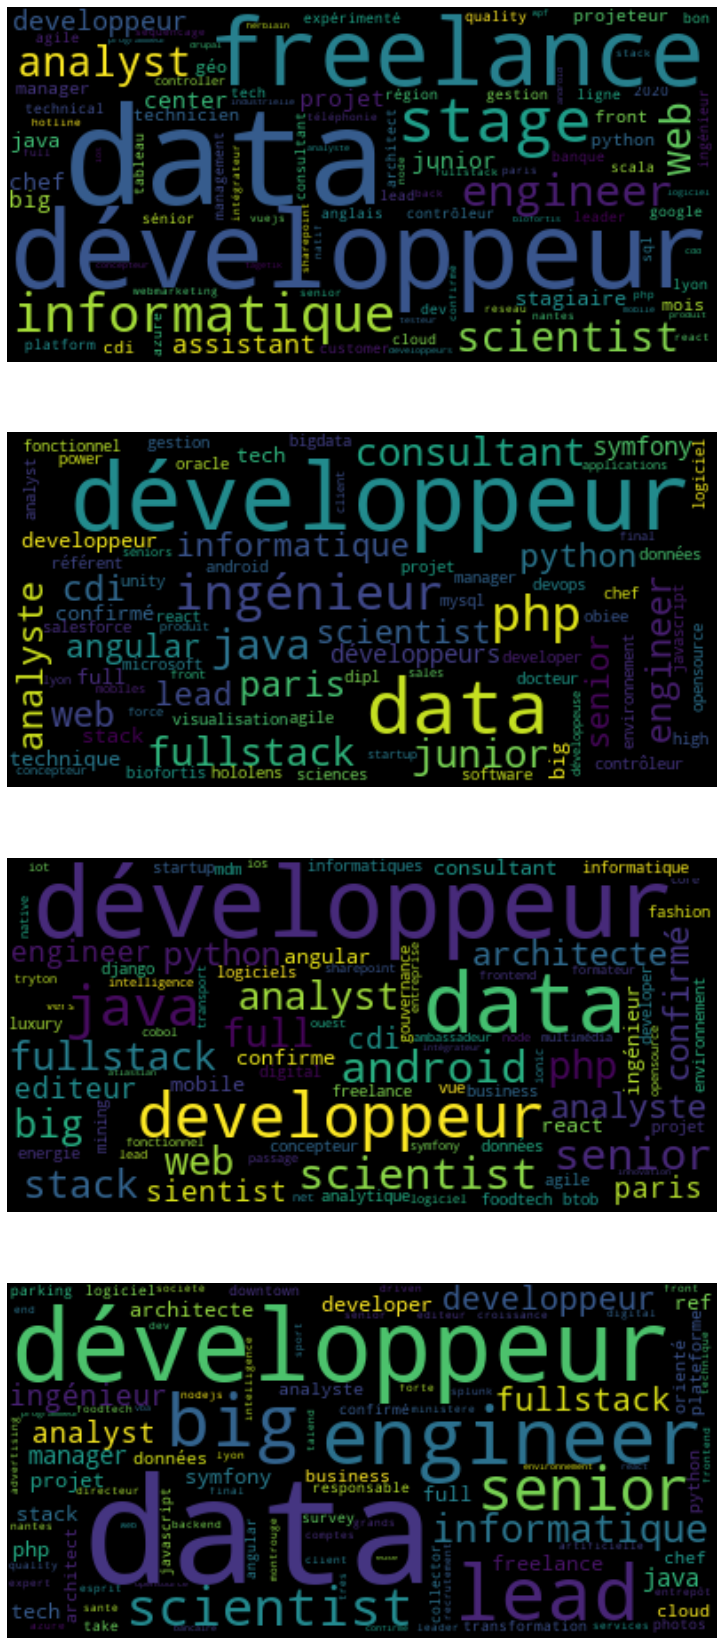

In [273]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize = (25, 30))

plt.figure(1)
plt.subplot(4, 1, 1)
plt.imshow(wordcloud_0, interpolation="bilinear")
plt.axis("off")

plt.subplot(4, 1, 2)
plt.imshow(wordcloud_1, interpolation="bilinear")
plt.axis("off")

plt.subplot(4, 1, 3)
plt.imshow(wordcloud_2, interpolation="bilinear")
plt.axis("off")

plt.subplot(4, 1, 4)
plt.imshow(wordcloud_3, interpolation="bilinear")
plt.axis("off")
plt.show()

In [282]:
df_salary[df_salary['Title'].str.contains('Freelance')]

,_id,Title,Company,Location,Salary,Description,Date,Job_Search,Department_Search,city,cp,salary_min,salary_max,salary_mean,salary_label,label_salary_min
3,p_9ba1a3ab379e9b6e,Data Engineer (H/F) / Freelance,Human Job,Paris (75),500 € par mois,Soutenir le développement de la plateforme BIG...,07/10/2019,Data,75,Paris,75,6000.0,6000.0,6000.0,0,0
4,p_8ccc668de734a40e,Data Engineer (H/F) / Freelance,HR-TEAM,Paris (75),500 € - 650 € par mois,Contexte : Nous recherchons aujourd’hui plusie...,07/10/2019,Data,75,Paris,75,6000.0,7800.0,6900.0,0,0
78,p_304ec1611bf99c34,Data scientist / Freelance,INFOTEL CONSEIL,Paris (75),520 € par semaine,Nous recherchons pour l’un de nos clients basé...,04/10/2019,Data,75,Paris,75,27040.0,27040.0,27040.0,0,0
93,p_4d857897fd7c92aa,Consultant Expérimenté - Data Quality H/F / Fr...,Thiveo,Paris (75),600 € par semaine,"L’un de nos clients, dans le secteur bancaire,...",04/10/2019,Data,75,Paris,75,31200.0,31200.0,31200.0,0,1
170,p_9f9f1edc2b9cf0f3,Data Engineer Azure / Freelance,AIM CONSULTING,Paris (75),450 € par semaine,Nous recherchons pour l’un de nos clients situ...,02/10/2019,Data,75,Paris,75,23400.0,23400.0,23400.0,0,0
181,p_d9523fdc354703df,Data Technical Leader Google Cloud Platform / ...,OZITEM,Paris (75),550 € par mois,Je recherche aujourd’hui un Data Technical Lea...,02/10/2019,Data,75,Paris,75,6600.0,6600.0,6600.0,0,0
226,p_b974f66542f8f953,Data Engineer / Banque en ligne / Freelance,AMETIX,Paris (75),500 € par mois,Le Data Engineer intervient auprès des équipes...,01/10/2019,Data,75,Paris,75,6000.0,6000.0,6000.0,0,0
288,pj_9378978b24a0ce53,Tech Lead BIG DATA - REF K - Freelance H/F,TEAM CONSULTING SARL,Paris (75),300 € - 500 € par jour,"Pour un de nos clients grand-comptes, nous rec...",NaN,Data,75,Paris,75,300.0,NaN,NaN,3,0
296,p_ff55a22d7ecb3d48,Data Engineer Sénior / Freelance,Cherry Pick,Paris (75),700 € par mois,Cherry Pick recherche pour l’un de ses clients...,30/09/2019,Data,75,Paris,75,8400.0,8400.0,8400.0,0,0
301,p_feec14496bca74e9,QA Data h/f / Freelance,Thiveo,Paris (75),600 € par mois,L’un de mes clients dans le secteur des termin...,27/09/2019,Data,75,Paris,75,7200.0,7200.0,7200.0,0,0


### Création de la fonction qui retourne les mots relevants sur la colonne desc

In [283]:
def clean_summary(desc):
    desc = word_tokenize(desc)
    #desc = [word.lower() for word in desc if word.isalpha() and len(word)>2]
    desc = [word.lower() for word in desc if (word.isalpha() or word.isdigit()) and len(word)>2]
    desc = [word for word in desc if (word not in stop_words_en) and (word not in stop_words_fr)]
    return desc

In [284]:
#stopwords
stop_words_en = stopwords.words('english')
stop_words_fr = stopwords.words('french')

### on applique la fonction sur chaque df salary

In [285]:
tag_desc_0 = label_0["Description"].apply(clean_summary)
tag_desc_1 = label_1["Description"].apply(clean_summary)    
tag_desc_2 = label_2["Description"].apply(clean_summary)
tag_desc_3 = label_3["Description"].apply(clean_summary)

In [286]:
tag_desc_3

1       [technology, domains, kafka, spark, python, ja...
24      [intrigué, potentiel, facebook, recrutement, v...
29      [areas, data, science, media, effectiveness, r...
89      [python, business, analysis, analyse, fonction...
105     [propos, monde, demain, entre, mains, rejoigne...
                              ...                        
1340    [descriptif, societe, cette, créé, 2018, récem...
1430    [opérateur, énergie, présent, plus, pays, enga...
1438    [expectra, leader, france, spécialisé, recrute...
1447    [contexte, recherche, entreprise, ambiance, co...
1538    [poste, missions, cadre, fort, développement, ...
Name: Description, Length: 70, dtype: object

# création des dictionnaires qui à chaque mot associe sa frequence

In [287]:
desc_0 = tag_desc_0.apply(Counter).sum().items()
desc_0 = sorted(desc_0, key=lambda kv : kv[1], reverse=True) 
dict_desc_0 = {k: v for k,v in desc_0}


desc_1 = tag_desc_1.apply(Counter).sum().items()
desc_1 = sorted(desc_1, key=lambda kv : kv[1], reverse=True) 
dict_desc_1 = {k: v for k,v in desc_1}

desc_2 = tag_desc_2.apply(Counter).sum().items()
desc_2 = sorted(desc_2, key=lambda kv : kv[1], reverse=True) 
dict_desc_2 = {k: v for k,v in desc_2}

desc_3 = tag_desc_3.apply(Counter).sum().items()
desc_3 = sorted(desc_3, key=lambda kv : kv[1], reverse=True) 
dict_desc_3 = {k: v for k,v in desc_3}

# Visualisation du wordcloud job_desc pour chaque df

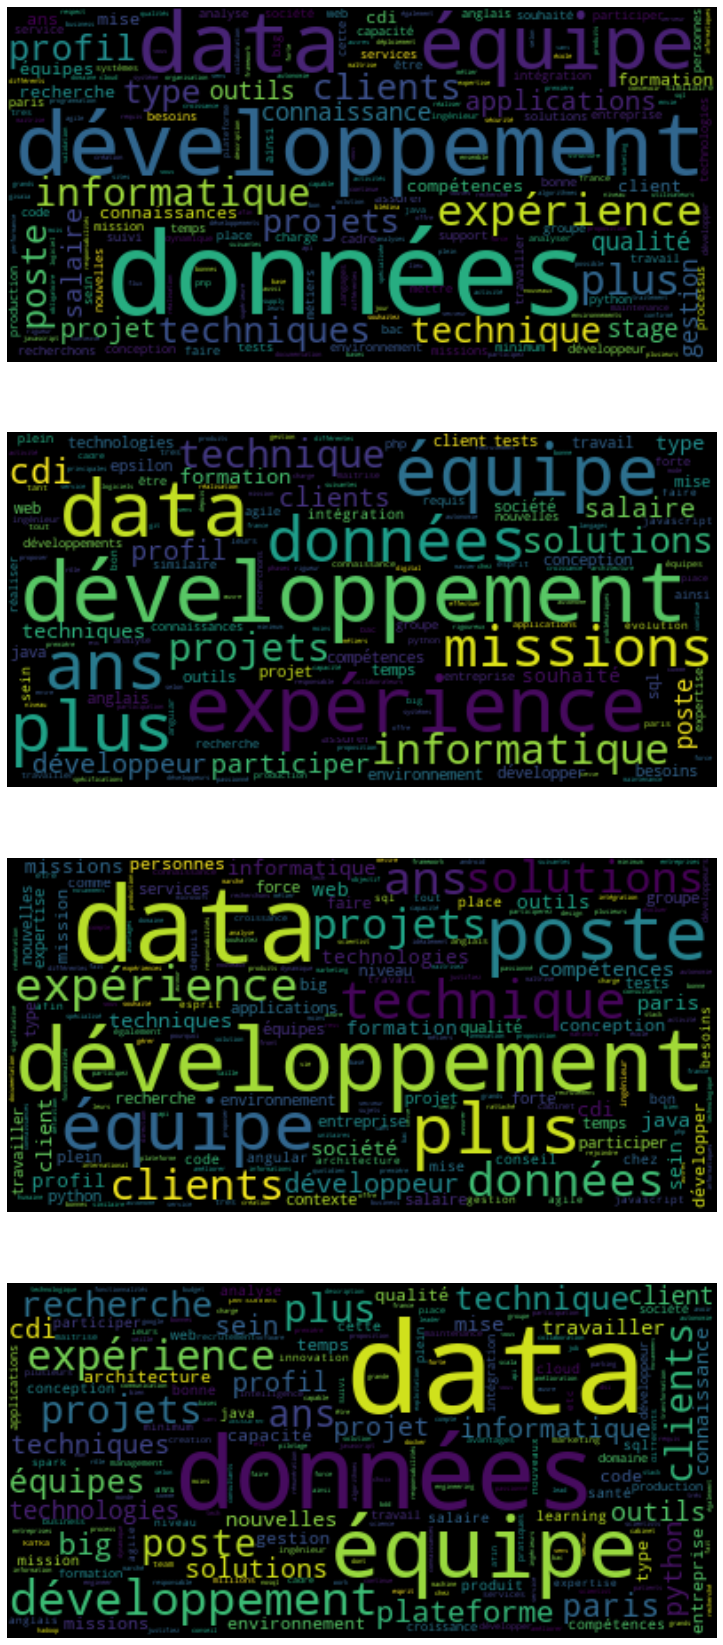

In [288]:
wordcloud5 = WordCloud().generate_from_frequencies(dict_desc_0)
wordcloud6 = WordCloud().generate_from_frequencies(dict_desc_1)
wordcloud7 = WordCloud().generate_from_frequencies(dict_desc_2)
wordcloud8 = WordCloud().generate_from_frequencies(dict_desc_3)

figure = plt.figure(figsize = (25, 30))
plt.figure(1)
plt.subplot(4, 1, 1)
plt.imshow(wordcloud5, interpolation="bilinear")
plt.axis("off")

plt.subplot(4, 1, 2)
plt.imshow(wordcloud6, interpolation="bilinear")
plt.axis("off")

plt.subplot(4, 1, 3)
plt.imshow(wordcloud7, interpolation="bilinear")
plt.axis("off")

plt.subplot(4, 1, 4)
plt.imshow(wordcloud8, interpolation="bilinear")
plt.axis("off")
plt.show()

## prediction salaire avec job desc brut seulement

In [68]:
from sklearn.feature_extraction.text import CountVectorizer

In [310]:
X_desc = df_salary.Description.str.replace("\n"," ")
y = df_salary.salary_label

In [311]:
stop_words_en_fr = stop_words_en + stop_words_fr

In [320]:
cv = CountVectorizer(stop_words=stop_words_en_fr, token_pattern=r'\b[^\d_\W]+\b', binary=True)
cv.fit(X_desc)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, token_pattern='\\b[^\\d_\\W]+\\b',
                tokenizer=None, vocabulary=None)

In [321]:
len(cv.get_feature_names())

6586

In [322]:
X_desc_trans = pd.DataFrame(cv.transform(X_desc).todense(), columns=cv.get_feature_names())
X_desc_trans

,abb,abglais,ability,abondement,abonnement,abord,abordables,aborder,abordez,absence,...,évolutivité,évolué,évènements,événementielles,événements,être,êtreen,île,œuvre,汉外双语招聘网
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
264,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
265,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [323]:
import numpy as np
np.asmatrix(X_desc_trans)

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [324]:
word_counts = X_desc_trans.sum(axis=0)
word_counts.sort_values(ascending = False).head(20)

expérience       211
développement    183
équipe           182
profil           162
poste            157
plus             155
informatique     151
ans              147
cdi              146
data             138
technique        137
projets          131
salaire          128
clients          127
missions         126
type             125
e                122
formation        120
bac              115
techniques       111
dtype: int64

In [325]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


X_train, X_test, y_train, y_test = train_test_split(np.asmatrix(X_desc_trans), y, test_size=0.3, random_state=0, stratify=y)


rfc = RandomForestClassifier(300, random_state=0)
rfc.fit(X_train, y_train)

rfc.score(X_test,y_test)

0.5061728395061729

In [328]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_desc_trans.columns).reset_index()
feature_importances.columns = ['feature', 'importance']

feature_importances.sort_values('importance', ascending=False).head(30)

,feature,importance
5295,salaire,0.004734
913,cdi,0.003905
2003,développeurs,0.003733
4187,participer,0.003648
442,architecture,0.003619
344,ans,0.003561
1288,connaissance,0.003540
1996,développements,0.003463
4641,projets,0.003054
5549,souhaité,0.002853


# Prédiction salaire avec Title seulement

In [296]:
X_title = df_salary.Title.str.replace("\n"," ").str.replace("/"," ")
y = df_salary.salary_label

In [313]:
cv2 = CountVectorizer(token_pattern=r'\b[^\d_\W]+\b', stop_words=stop_words_fr, binary=True)
cv2.fit(X_title)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de',
                            'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils',
                            'je', 'la', 'le', 'les', 'leur', 'lui', 'ma',
                            'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne',
                            'nos', ...],
                strip_accents=None, token_pattern='\\b[^\\d_\\W]+\\b',
                tokenizer=None, vocabulary=None)

In [314]:
len(cv2.get_feature_names())

247

In [315]:
X_title_trans = pd.DataFrame(cv.transform(X_title).todense(), columns=cv2.get_feature_names())
X_title_trans

,advertising,affaires,agile,ambassadeur,analyst,analyste,analytique,android,anglais,angular,...,vente,vers,ville,visualisation,vue,vuejs,web,webmarketing,wpf,éditeur
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
263,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
264,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
265,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [316]:
word_counts2 = X_title_trans.sum(axis=0)
word_counts2.sort_values(ascending = False).head(30)

f               156
h               156
data            131
développeur     120
java             26
freelance        24
engineer         23
developpeur      23
scientist        20
big              19
informatique     19
php              17
web              16
fullstack        16
ingénieur        16
senior           15
stack            15
analyst          15
full             15
lead             14
net              14
end              10
analyste         10
python           10
js                9
front             9
stage             8
consultant        8
projet            8
cdi               8
dtype: int64

In [317]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(np.asmatrix(X_title_trans), y, test_size=0.3, random_state=10, stratify=y)


rfc = RandomForestClassifier(300, random_state=0)
rfc.fit(X_train2, y_train2)

rfc.score(X_test2,y_test2)

0.43209876543209874

In [318]:
rfc.feature_importances_

array([0.        , 0.0005223 , 0.00239038, 0.0025603 , 0.00859124,
       0.0168218 , 0.00597484, 0.00843668, 0.00059287, 0.0084855 ,
       0.00261433, 0.        , 0.00619122, 0.00344803, 0.00899784,
       0.00099773, 0.00665236, 0.00300361, 0.        , 0.00059873,
       0.0018243 , 0.00254667, 0.00224409, 0.        , 0.00210875,
       0.00137405, 0.01101176, 0.01576595, 0.00279528, 0.00163034,
       0.00077894, 0.00269563, 0.00280249, 0.        , 0.01621076,
       0.01020063, 0.002973  , 0.00383688, 0.00104653, 0.00350568,
       0.00394224, 0.        , 0.00093853, 0.00680259, 0.00357883,
       0.00724631, 0.01709727, 0.00459726, 0.00367955, 0.        ,
       0.00062388, 0.00045721, 0.0214608 , 0.00123137, 0.00817996,
       0.01625382, 0.00317322, 0.00341463, 0.00343827, 0.        ,
       0.        , 0.00178616, 0.        , 0.00278743, 0.        ,
       0.00071941, 0.        , 0.02683849, 0.00242308, 0.        ,
       0.00453419, 0.00067926, 0.00584182, 0.00209811, 0.02006

In [319]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_title_trans.columns).reset_index()
feature_importances.columns = ['feature', 'importance']

feature_importances.sort_values('importance', ascending=False).head(20)

,feature,importance
90,freelance,0.041350
112,informatique,0.030609
67,développeur,0.026838
103,h,0.025119
210,stage,0.023230
128,lead,0.023203
82,f,0.022698
114,ingénieur,0.022358
52,data,0.021461
166,php,0.020696
